In [1]:
import os
import torch
import shutil
import numpy as np

from PIL import Image
from tqdm import tqdm
from urllib.request import urlretrieve
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from oxford_pet import OxfordPetDataset, SimpleOxfordPetDataset,load_dataset

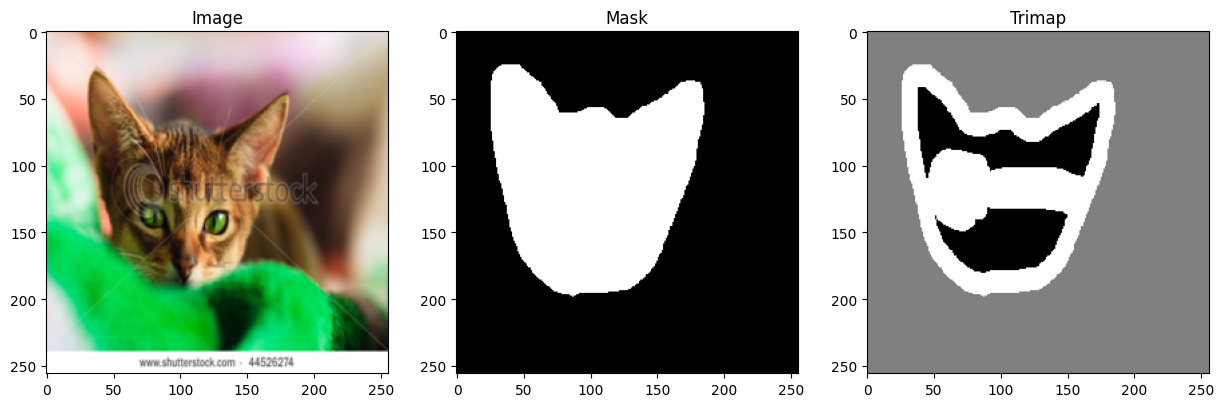

In [2]:
data_root = '../dataset'
dataset = SimpleOxfordPetDataset(root=data_root, mode="train", transform=None)
sample = dataset[0]

image = sample["image"]
mask = sample["mask"]
trimap = sample["trimap"]

image = np.transpose(image, (1, 2, 0))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Image")

ax[1].imshow(mask[0], cmap="gray")  
ax[1].set_title("Mask")

ax[2].imshow(trimap[0], cmap="gray") 
ax[2].set_title("Trimap")

plt.show()

In [7]:
train_loader = load_dataset(data_root, "train")
valid_loader = load_dataset(data_root, "valid")
test_loader = load_dataset(data_root, "test")

train_sample = next(iter(train_loader))
print("Train sample shapes:")
print("Image shape:", train_sample['image'].shape)
print("Mask shape:", train_sample['mask'].shape)
print("Trimap shape:", train_sample['trimap'].shape)

Train sample shapes:
Image shape: torch.Size([16, 3, 256, 256])
Mask shape: torch.Size([16, 1, 256, 256])
Trimap shape: torch.Size([16, 1, 256, 256])


In [ ]:
from tqdm import tqdm
from unet_unpadding import UNet
import torch
import torch.nn as nn
import torch.optim as optim

model = UNet(in_channels=3, out_channels=2)  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()  # 根據你的任務選擇適合的損失函數
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch in tqdm(dataloader, desc="Training"):
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=25):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # 訓練階段
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f"Training Loss: {train_loss:.4f}")

        # 驗證階段
        valid_loss = validate_one_epoch(model, valid_loader, criterion, device)
        print(f"Validation Loss: {valid_loss:.4f}")

    print("Training complete.")

# 訓練模型
train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=25)